In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as dset

# Directory containing the data.
root = '/kaggle/input/cifar10-python'

def get_data(params):
    """
    Loads the dataset and applies proproccesing steps to it.
    Returns a PyTorch DataLoader.
    """
    # Data proprecessing.
    transform = transforms.Compose([
        transforms.Resize(params['A']),
        transforms.ToTensor()])

    # Create the dataset.
    dataset = dset.CIFAR10(root=root, train=True, download=True, transform=transform)

    # Create the dataloader.
    dataloader = torch.utils.data.DataLoader(dataset,
        batch_size=params['batch_size'],
        shuffle=True)

    return dataloader

In [2]:
import torch.nn as nn
import torchvision.utils as vutils
import numpy as np

"""
The equation numbers on the comments corresponding
to the relevant equation given in the paper:
DRAW: A Recurrent Neural Network For Image Generation.
"""

class DRAWModel(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.T = params['T']
        self.A = params['A']
        self.B = params['B']
        self.z_size = params['z_size']
        self.read_N = params['read_N']
        self.write_N = params['write_N']
        self.enc_size = params['enc_size']
        self.dec_size = params['dec_size']
        self.device = params['device']
        self.channel = params['channel']

        # Stores the generated image for each time step.
        self.cs = [0] * self.T
        
        # To store appropriate values used for calculating the latent loss (KL-Divergence loss)
        self.logsigmas = [0] * self.T
        self.sigmas = [0] * self.T
        self.mus = [0] * self.T

        self.encoder = nn.LSTMCell(2*self.read_N*self.read_N*self.channel + self.dec_size, self.enc_size)

        # To get the mean and standard deviation for the distribution of z.
        self.fc_mu = nn.Linear(self.enc_size, self.z_size)
        self.fc_sigma = nn.Linear(self.enc_size, self.z_size)

        self.decoder = nn.LSTMCell(self.z_size, self.dec_size)

        self.fc_write = nn.Linear(self.dec_size, self.write_N*self.write_N*self.channel)

        # To get the attention parameters. 5 in total.
        self.fc_attention = nn.Linear(self.dec_size, 5)

    def forward(self, x):
        self.batch_size = x.size(0)

        # requires_grad should be set True to allow backpropagation of the gradients for training.
        h_enc_prev = torch.zeros(self.batch_size, self.enc_size, requires_grad=True, device=self.device)
        h_dec_prev = torch.zeros(self.batch_size, self.dec_size, requires_grad=True, device=self.device)

        enc_state = torch.zeros(self.batch_size, self.enc_size, requires_grad=True, device=self.device)
        dec_state = torch.zeros(self.batch_size, self.dec_size, requires_grad=True, device=self.device)

        for t in range(self.T):
            c_prev = torch.zeros(self.batch_size, self.B*self.A*self.channel, requires_grad=True, device=self.device) if t == 0 else self.cs[t-1]
            # Equation 3.
            x_hat = x - torch.sigmoid(c_prev)
            # Equation 4.
            # Get the N x N glimpse.
            r_t = self.read(x, x_hat, h_dec_prev)
            # Equation 5.
            h_enc, enc_state = self.encoder(torch.cat((r_t, h_dec_prev), dim=1), (h_enc_prev, enc_state))
            # Equation 6.
            z, self.mus[t], self.logsigmas[t], self.sigmas[t] = self.sampleQ(h_enc)
            # Equation 7.
            h_dec, dec_state = self.decoder(z, (h_dec_prev, dec_state))
            # Equation 8.
            self.cs[t] = c_prev + self.write(h_dec)

            h_enc_prev = h_enc
            h_dec_prev = h_dec

    def read(self, x, x_hat, h_dec_prev):
        # Using attention
        (Fx, Fy), gamma = self.attn_window(h_dec_prev, self.read_N)

        def filter_img(img, Fx, Fy, gamma):
            Fxt = Fx.transpose(self.channel, 2)
            if self.channel == 3:
                img = img.view(-1, 3, self.B, self.A)
            elif self.channel == 1:
                img = img.view(-1, self.B, self.A)

            # Equation 27.
            glimpse = torch.matmul(Fy, torch.matmul(img, Fxt))
            glimpse = glimpse.view(-1, self.read_N*self.read_N*self.channel)

            return glimpse * gamma.view(-1, 1).expand_as(glimpse)

        x = filter_img(x, Fx, Fy, gamma)
        x_hat = filter_img(x_hat, Fx, Fy, gamma)

        return torch.cat((x, x_hat), dim=1)
        # No attention
        #return torch.cat((x, x_hat), dim=1)

    def write(self, h_dec):
        # Using attention
        # Equation 28.
        w = self.fc_write(h_dec)
        if self.channel == 3:
            w = w.view(self.batch_size, 3, self.write_N, self.write_N)
        elif self.channel == 1:
            w = w.view(self.batch_size, self.write_N, self.write_N)

        (Fx, Fy), gamma = self.attn_window(h_dec, self.write_N)
        Fyt = Fy.transpose(self.channel, 2)

        # Equation 29.
        wr = torch.matmul(Fyt, torch.matmul(w, Fx))
        wr = wr.view(self.batch_size, self.B*self.A*self.channel)

        return wr / gamma.view(-1, 1).expand_as(wr)
        # No attention
        #return self.fc_write(h_dec)

    def sampleQ(self, h_enc):
        e = torch.randn(self.batch_size, self.z_size, device=self.device)

        # Equation 1.
        mu = self.fc_mu(h_enc)
        # Equation 2.
        log_sigma = self.fc_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        
        z = mu + e * sigma

        return z, mu, log_sigma, sigma

    def attn_window(self, h_dec, N):
        # Equation 21.
        params = self.fc_attention(h_dec)
        gx_, gy_, log_sigma_2, log_delta_, log_gamma = params.split(1, 1)

        # Equation 22.
        gx = (self.A + 1) / 2 * (gx_ + 1)
        # Equation 23
        gy = (self.B + 1) / 2 * (gy_ + 1)
        # Equation 24.
        delta = (max(self.A, self.B) - 1) / (N - 1) * torch.exp(log_delta_)
        sigma_2 = torch.exp(log_sigma_2)
        gamma = torch.exp(log_gamma)

        return self.filterbank(gx, gy, sigma_2, delta, N), gamma

    def filterbank(self, gx, gy, sigma_2, delta, N, epsilon=1e-8):
        grid_i = torch.arange(start=0.0, end=N, device=self.device, requires_grad=True,).view(1, -1)
        
        # Equation 19.
        mu_x = gx + (grid_i - N / 2 - 0.5) * delta
        # Equation 20.
        mu_y = gy + (grid_i - N / 2 - 0.5) * delta

        a = torch.arange(0.0, self.A, device=self.device, requires_grad=True).view(1, 1, -1)
        b = torch.arange(0.0, self.B, device=self.device, requires_grad=True).view(1, 1, -1)

        mu_x = mu_x.view(-1, N, 1)
        mu_y = mu_y.view(-1, N, 1)
        sigma_2 = sigma_2.view(-1, 1, 1)

        # Equations 25 and 26.
        Fx = torch.exp(-torch.pow(a - mu_x, 2) / (2 * sigma_2))
        Fy = torch.exp(-torch.pow(b - mu_y, 2) / (2 * sigma_2))

        Fx = Fx / (Fx.sum(2, True).expand_as(Fx) + epsilon)
        Fy = Fy / (Fy.sum(2, True).expand_as(Fy) + epsilon)

        if self.channel == 3:
            Fx = Fx.view(Fx.size(0), 1, Fx.size(1), Fx.size(2))
            Fx = Fx.repeat(1, 3, 1, 1)
            
            Fy = Fy.view(Fy.size(0), 1, Fy.size(1), Fy.size(2))
            Fy = Fy.repeat(1, 3, 1, 1)

        return Fx, Fy

    def loss(self, x):
        self.forward(x)

        criterion = nn.BCELoss()
        x_recon = torch.sigmoid(self.cs[-1])
        # Reconstruction loss.
        # Only want to average across the mini-batch, hence, multiply by the image dimensions.
        Lx = criterion(x_recon, x) * self.A * self.B * self.channel
        # Latent loss.
        Lz = 0

        for t in range(self.T):
            mu_2 = self.mus[t] * self.mus[t]
            sigma_2 = self.sigmas[t] * self.sigmas[t]
            logsigma = self.logsigmas[t]

            kl_loss = 0.5*torch.sum(mu_2 + sigma_2 - 2*logsigma, 1) - 0.5*self.T
            Lz += kl_loss

        Lz = torch.mean(Lz)
        net_loss = Lx + Lz

        return net_loss

    def generate(self, num_output):
        self.batch_size = num_output
        h_dec_prev = torch.zeros(num_output, self.dec_size, device=self.device)
        dec_state = torch.zeros(num_output, self.dec_size  , device=self.device)

        for t in range(self.T):
            c_prev = torch.zeros(self.batch_size, self.B*self.A*self.channel, device=self.device) if t == 0 else self.cs[t-1]
            z = torch.randn(self.batch_size, self.z_size, device=self.device)
            h_dec, dec_state = self.decoder(z, (h_dec_prev, dec_state))
            self.cs[t] = c_prev + self.write(h_dec)
            h_dec_prev = h_dec

        imgs = []

        for img in self.cs:
            # The image dimesnion is B x A (According to the DRAW paper).
            img = img.view(-1, self.channel, self.B, self.A)
            imgs.append(vutils.make_grid(torch.sigmoid(img).detach().cpu(), nrow=int(np.sqrt(int(num_output))), padding=1, normalize=True, pad_value=1))

        return imgs

cuda  will be used.

Files already downloaded and verified
-------------------------
Starting Training Loop...

Epochs: 50
Batch Size: 128
Length of Data Loader: 391
-------------------------
[1/50][100/391]	Loss: 2968.3448
[1/50][200/391]	Loss: 2851.8646
[1/50][300/391]	Loss: 2817.9298
Time Taken for Epoch 1: 74.37s
[2/50][100/391]	Loss: 2826.6507
[2/50][200/391]	Loss: 2791.1170
[2/50][300/391]	Loss: 2788.5522
Time Taken for Epoch 2: 72.93s
[3/50][100/391]	Loss: 2810.5646
[3/50][200/391]	Loss: 2780.5414
[3/50][300/391]	Loss: 2778.9045
Time Taken for Epoch 3: 72.91s
[4/50][100/391]	Loss: 2801.7417
[4/50][200/391]	Loss: 2775.1576
[4/50][300/391]	Loss: 2774.2277
Time Taken for Epoch 4: 73.05s
[5/50][100/391]	Loss: 2796.4851
[5/50][200/391]	Loss: 2771.5714
[5/50][300/391]	Loss: 2772.3789
Time Taken for Epoch 5: 73.25s
[6/50][100/391]	Loss: 2795.3292
[6/50][200/391]	Loss: 2764.7085
[6/50][300/391]	Loss: 2766.7220
Time Taken for Epoch 6: 73.25s
[7/50][100/391]	Loss: 2788.3577
[7/50][200/391

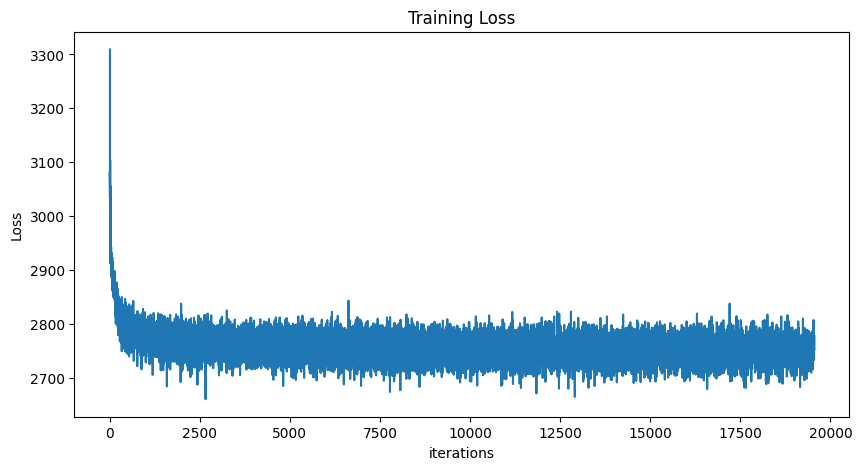

In [3]:
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from torchvision import datasets, transforms
import os

checkpoint_dir = '/kaggle/working/checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to generate new images and save the time-steps as an animation.
def generate_image(epoch):
    x = model.generate(64)
    fig = plt.figure(figsize=(16, 16))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in x]
    anim = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)
    anim.save('/kaggle/working/draw_epoch_{}.gif'.format(epoch), dpi=100, writer='imagemagick')
    plt.close('all')

# Dictionary storing network parameters.
params = {
    'T' : 25,# Number of glimpses.
    'batch_size': 128,# Batch size.
    'A' : 32,# Image width
    'B': 32,# Image height
    'z_size' :100,# Dimension of latent space.
    'read_N' : 6,# N x N dimension of reading glimpse.
    'write_N' : 6,# N x N dimension of writing glimpse.
    'dec_size': 400,# Hidden dimension for decoder.
    'enc_size' :400,# Hidden dimension for encoder.
    'epoch_num': 50,# Number of epochs to train for.
    'learning_rate': 1e-3,# Learning rate.
    'beta1': 0.5,
    'clip': 5.0,
    'save_epoch' : 10,# After how many epochs to save checkpoints and generate test output.
    'channel' : None}# Number of channels for image.(3 for RGB, etc.)

# Use GPU is available else use CPU.
device = torch.device("cuda" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

params['device'] = device

train_loader = get_data(params)
params['channel'] = 3

"""
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train='train', download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()])),
    batch_size=params['batch_size'], shuffle=True)

params['channel'] = 1
"""

# Plot the training images.
sample_batch = next(iter(train_loader))
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 64], nrow=8, padding=1, normalize=True, pad_value=1).cpu(), (1, 2, 0)))
plt.savefig("/kaggle/working/Training_Data")

# Initialize the model.
model = DRAWModel(params).to(device)
# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], betas=(params['beta1'], 0.999))

# List to hold the losses for each iteration.
# Used for plotting loss curve.
losses = []
iters = 0
avg_loss = 0

print("-"*25)
print("Starting Training Loop...\n")
print('Epochs: %d\nBatch Size: %d\nLength of Data Loader: %d' % (params['epoch_num'], params['batch_size'], len(train_loader)))
print("-"*25)

start_time = time.time()

for epoch in range(params['epoch_num']):
    epoch_start_time = time.time()
    
    for i, (data, _ ) in enumerate(train_loader, 0):
        # Get batch size.
        bs = data.size(0)
        # Flatten the image.
        data = data.view(bs, -1).to(device)
        optimizer.zero_grad()
        # Calculate the loss.
        loss = model.loss(data)
        loss_val = loss.cpu().data.numpy()
        avg_loss += loss_val
        # Calculate the gradients.
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), params['clip'])
        # Update parameters.
        optimizer.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch+1, params['epoch_num'], i, len(train_loader), avg_loss / 100))

            avg_loss = 0
        
        losses.append(loss_val)
        iters += 1

    avg_loss = 0
    epoch_time = time.time() - epoch_start_time
    print("Time Taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    # Save checkpoint and generate test output.
    if (epoch+1) % params['save_epoch'] == 0:
        torch.save({
            'model' : model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'params' : params
            }, '/kaggle/working/checkpoint/model_epoch_{}'.format(epoch+1))
        
        with torch.no_grad():
            generate_image(epoch+1)

training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)
# Save the final trained network paramaters.
torch.save({
    'model' : model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'params' : params
    }, '/kaggle/working/checkpoint/model_final'.format(epoch))

# Generate test output.
with torch.no_grad():
    generate_image(params['epoch_num'])

# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.savefig("/kaggle/working/Loss_Curve")

/tmp/ipykernel_30/4142565237.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/checkpoint/model_final')




DRAWModel(
  (encoder): LSTMCell(616, 400)
  (fc_mu): Linear(in_features=400, out_features=100, bias=True)
  (fc_sigma): Linear(in_features=400, out_features=100, bias=True)
  (decoder): LSTMCell(100, 400)
  (fc_write): Linear(in_features=400, out_features=108, bias=True)
  (fc_attention): Linear(in_features=400, out_features=5, bias=True)
)
*************************
Generating Image...

DONE!
Time taken to generate image: 0.03s

Saving generated image...
DONE!
--------------------------------------------------


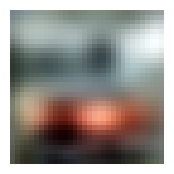

In [10]:
# Load the checkpoint file.
state_dict = torch.load('/kaggle/working/checkpoint/model_final')

# Set the device to run on: GPU or CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
# Get the 'params' dictionary from the loaded state_dict.
params = state_dict['params']

# Set the number of glimpses.
# Best to just use the same value which was used for training.
params['T'] = params['T']

# Load the model
model = DRAWModel(params).to(device)
# Load the trained parameters.
model.load_state_dict(state_dict['model'])
print('\n')
print(model)

start_time = time.time()
print('*'*25)
print("Generating Image...")
# Generate images.
with torch.no_grad():
    x = model.generate(int(1))

time_elapsed = time.time() - start_time
print('\nDONE!')
print('Time taken to generate image: %.2fs' % (time_elapsed))

print('\nSaving generated image...')
fig = plt.figure(figsize=(int(np.sqrt(int(1)))*2, int(np.sqrt(int(1)))*2))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    x[-1], nrow=int(np.sqrt(int(1))), padding=1, normalize=True, pad_value=1).cpu(), (1, 2, 0)))
plt.savefig("Generated_Image")
plt.close('all')

# Create animation for the generation.
fig = plt.figure(figsize=(int(np.sqrt(int(1)))*2, int(np.sqrt(int(1)))*2))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in x]
anim = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=2000, blit=True)
anim.save('draw_generate.gif', dpi=100, writer='imagemagick')
print('DONE!')
print('-'*50)
plt.show()